<a href="https://colab.research.google.com/github/OmerAGilin/Road2-AI-Course/blob/main/Road2_AI_Course_lesson_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

good afternoon, please prepare to write code in python and keras, but don't write anything yet, and be aware that i'm using google colab

please write a code that imports VGG-19 and prints the network's summary

In [15]:
# Importing necessary libraries
from keras.applications import VGG19

# Load the VGG-19 model pre-trained on ImageNet data
vgg19_model = VGG19(weights='imagenet')

# Print the summary of the VGG-19 model
vgg19_model.summary()


574710816/574710816 [==============================] - 7s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

please write a code that imports VGG-19, and freezes all its layers up until the last maxpooling (block5_pool).

in the end, the network uses softmax and chooses the most problable class out of the two classes as the output. the classes are:
1. cats
2. dogs

add a function that applies at random one of the following options to the image before inputting it into the network:
1. no augmentation
2. random flip augmentation
3. color jitter augmentation
4. rotation augmentation

retrain the network using the training dataset in this path: /content/drive/MyDrive/Road2/AI_Course/lesson_8/dataset/train, and then print its learning curve and its summary



+

please write a code that test the network using the testing dataset in this path: /content/drive/MyDrive/Road2/AI_Course/lesson_8/dataset/validation, adds to the learning curve from before a graph of the test's results, and then prints a confusion matrix of the test's result

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

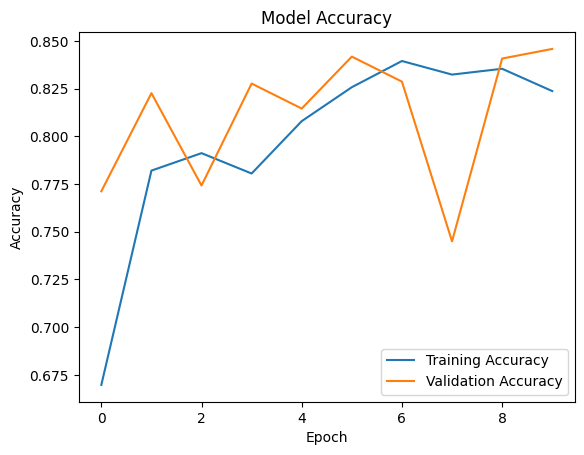

32/32 [==============================] - 5s 158ms/step - loss: 0.3466 - accuracy: 0.8460
Test Accuracy: 84.60%
32/32 [==============================] - 6s 165ms/step


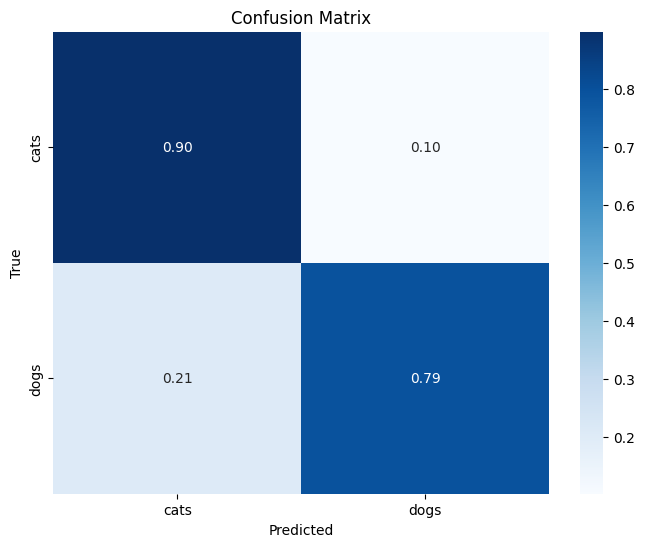

Classification Report:
               precision    recall  f1-score   support

        cats       0.81      0.90      0.85       500
        dogs       0.89      0.79      0.84       500

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



In [24]:
import os
import random
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications import VGG19
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

# Set the random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

# Define the classes
classes = ['cats', 'dogs']
num_classes = len(classes)

# Function for data augmentation
def apply_data_augmentation(img):
    # Randomly choose one of the augmentation options
    choice = random.choice(['no_augmentation', 'random_flip', 'color_jitter', 'rotation'])

    if choice == 'no_augmentation':
        return img
    elif choice == 'random_flip':
        return np.fliplr(img)
    elif choice == 'color_jitter':
        # Apply color jittering (you can customize this further)
        img += np.random.uniform(-10, 10, img.shape).astype('uint8')
        return np.clip(img, 0, 255)
    elif choice == 'rotation':
        # Apply random rotation (you can customize this further)
        angle = random.uniform(-30, 30)
        return np.array(Image.fromarray(img).rotate(angle))

# Load the VGG-19 model with pre-trained weights
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers up to the last max pooling layer (block5_pool)
for layer in base_model.layers:
    if layer.name == 'block5_pool':
        break
    layer.trainable = False

# Add a new fully connected layer and softmax layer for the new classes
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

# Define the paths to the training data
train_data_dir = '/content/drive/MyDrive/Road2/AI_Course/lesson_8/dataset/train'
validation_data_dir = '/content/drive/MyDrive/Road2/AI_Course/lesson_8/dataset/validation'

# Define image data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Train the model with validation data
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Plot the learning curve including validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the validation set
evaluation = model.evaluate(validation_generator)

# Print the test accuracy
print(f'Test Accuracy: {evaluation[1]*100:.2f}%')

# Make predictions on the validation set
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_labels = validation_generator.classes

# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)
class_names = list(validation_generator.class_indices.keys())

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt=".2f")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(true_labels, predicted_classes, target_names=class_names))


**using vgg-19 as a base and applying augmentations to the images in order to simulate a bigger dataset did seem to increase the model's accuracy, as we got a higher accuracy rate than the model in excersize 5**

can you please rewrite the last code snippet, but this time write it using pytorch instead of keras?

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

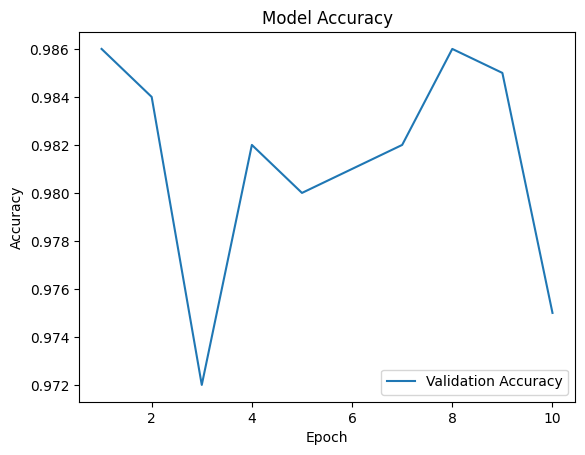

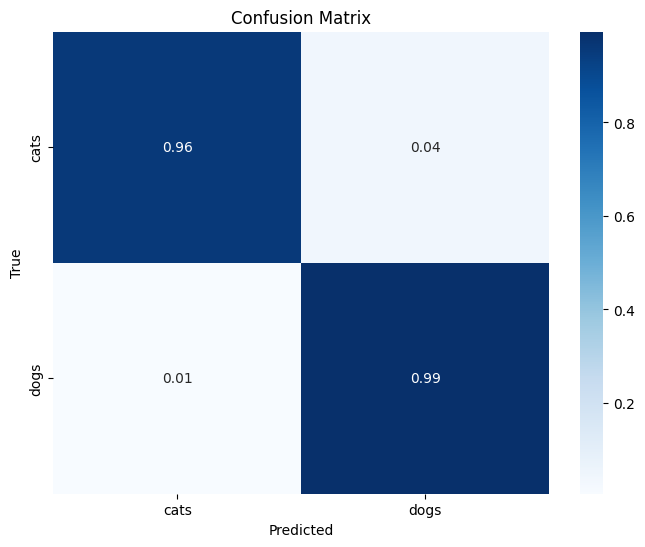

Classification Report:
               precision    recall  f1-score   support

        cats       0.99      0.96      0.97       500
        dogs       0.96      0.99      0.98       500

    accuracy                           0.97      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.98      0.97      0.97      1000



In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the classes
classes = ['cats', 'dogs']
num_classes = len(classes)

# Define data transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the pre-trained VGG-19 model
vgg19_model = models.vgg19(pretrained=True)
# Freeze layers up to the last max pooling layer (features.18)
for param in vgg19_model.features.parameters():
    param.requires_grad = False

# Modify the classifier for the new classes
vgg19_model.classifier[-1] = nn.Linear(4096, num_classes)

# Move the model to the device
vgg19_model = vgg19_model.to(device)

# Print the summary of the model
summary(vgg19_model, input_size=(3, 224, 224))

# Define data loaders for training and validation
train_data_dir = '/content/drive/MyDrive/Road2/AI_Course/lesson_8/dataset/train'
validation_data_dir = '/content/drive/MyDrive/Road2/AI_Course/lesson_8/dataset/validation'

train_dataset = datasets.ImageFolder(root=train_data_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=validation_data_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19_model.parameters(), lr=0.0001)

# Train the model
num_epochs = 10
val_accuracies = []

for epoch in range(num_epochs):
    vgg19_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg19_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    vgg19_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg19_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print the validation accuracy
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)  # Store validation accuracy

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Accuracy: {val_accuracy * 100:.2f}%')

# Plot the learning curve
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the validation set
conf_matrix = []
true_labels = []
predicted_labels = []

vgg19_model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg19_model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = ['cats', 'dogs']

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt=".2f")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=class_names))


**it seems that using pytorch instead of keras yield amazingly better results, why is that?**